In this notebook, we will perform Bayesian inference (BI) for rheological measurements at a constant shear rate. Much of the content shown here is has been adapted from the work of Rappel et al. [H. Rappel et al., "A tutorial on Bayesian inference to identify material parameters in solid mechanics." Archives of Computational Methods in Engineering 27.2 (2020): 361-385.]. We will assume that the fluid is Newtonian, thus the shear stress is a linear function of shear rate: $$\tau = \eta \dot{\gamma},$$ where $\tau$ is the shear stress, $\dot{\gamma}$ is the shear rate and $\eta$ is the viscosity.

In BI, we assume that a model, or specifally the model parameters, cannot be known with absolute certainty. This uncertainty is reflected by considering the model parameters as random variables with some underlying probability distribution function (PDF). The ratio between the standard deviation and the mean of the PDF is a measure for the uncertainty. The set of uncertain model parameters is denoted by $\boldsymbol{m}$, and for the case of a Newtonian fluid we have $$\boldsymbol{m}=\{\eta\}.$$
The shear rate $\dot{\gamma}$ can also be condidered a model parameter with its own uncertainty. However, we assume here the variable of $\dot{\gamma}$ is much smaller than that of $\eta$, thus we consider it to be known with absolute certainty (i.e. it is a deterministic parameters). To determine the model parameters $\boldsymbol{m}$, we typically perform measurements, yielding values for the *observables* of our system. The set of observables is denoted by $\boldsymbol{d}$. Rheological measurements are typically done by imposing a shear rate and observing the shear stress. We can thus write $$\boldsymbol{d} = \{\tau\}\text{.}$$

Finally, we introduce a forward model operator $\boldsymbol{g}$, which relates the model parameters and the observables: $$\boldsymbol{d} = \boldsymbol{g}(\boldsymbol{m}).$$ 
The model operator $\boldsymbol{g}$ allows us to determine the observables $\boldsymbol{d}$ given a realization of the model parameters $\boldsymbol{m}$ and the deterministic parameters. For the Newtonian fluid considered here, the forward model operator is simply the Newtonian law as given above.

When performing experiments, the observables will generally by corrupted by noise and the chosen model might not be able to describe the data. The actually observed values are thus $$\boldsymbol{y}_i = \boldsymbol{g}_i(\boldsymbol{m}) + \boldsymbol{\epsilon} \quad \text{for } 1 \leq i \leq N,$$ where $N$ is the number of measurements, $\boldsymbol{y}_i$ is the measured observable, $\boldsymbol{g}_i$ is the forward model (including the deterministic parameters, which might vary with $i$) and $\boldsymbol{\epsilon}$ is a random variable representing the total noise, which contains contributions from both measurement noise and model inadequacy, which for now we will assume to be additive and known. For the Newtonian model we get $$\tau^\text{e}_i = \eta \dot{\gamma}_i + \epsilon \quad \text{for } 1 \leq i \leq N,$$ where $\tau^\text{e}_i$ is the experimentally measured shear stress.

We start by importing some standard libraries.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# use Latex for the labels in plots
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

# fix the seed for the RNG
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

Suppose we have some fluid with an actual viscosity of $\eta = 3$. For brevity we refrain from using units, i.e. all variables are appropriately non-dimensionalised. To determine the viscosity, we perform steady shear experiments, which gives us some stress strain-rate values. It is assumed that the noise in our measurements is Gaussian (i.e. is follows a normal distribution) with a mean of zero and a standard deviation (SD) of $\sigma_\text{noise} = 1.0$. The PDF for the noise thus reads $$\pi_\text{noise}(\omega)= \frac{1}{\sqrt{2\pi}\sigma_\text{noise}}\exp \left(-\frac{\omega^2}{2 \sigma_\text{noise}^2}\right)\text{,}$$ where $\omega$ is a dummy variable. In the next cell, we will use the PDF of the noise to generate our experimental data.

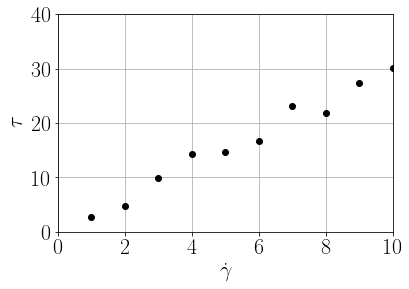

In [62]:
eta      = 3.0   # actual viscosity
sd_noise = 1.0   # standard deviation for the noise on the stress
nsample  = 10    # the number of datapoints that will be generated

# generate the strain rates
if nsample == 1:
  gammadot = np.array([5])
else:
  gammadot = np.linspace(0,10,nsample+1)
  gammadot = gammadot[1:] # remove the zero strain measurement

# generate the stress measurements
tau = eta*gammadot + np.random.normal(0, sd_noise, nsample)

# plot the generated data
plt.plot(gammadot,tau,'ko') 
plt.xlim([0, 10])
plt.ylim([0, 40])
plt.xlabel("$\\dot{\\gamma}$")
plt.ylabel("$\\tau$")
plt.grid()
plt.show()

BI is based on Bayes' rule, which is given by $$\pi(\boldsymbol{m}|\boldsymbol{y}) = \frac{\pi(\boldsymbol{y}|\boldsymbol{m})\pi(\boldsymbol{m})}{\pi(\boldsymbol{y})}\text{,}$$ which should be read as follows: the probability for a parameter value given measured data (with known deterministic parameters) is equal to the probility of observing the data given the parameter times the prior probability of the parameter over the probability of observing the data. For brevity, we introduce the following short-hand notation for the case of multiple measurement point: $$\pi(\boldsymbol{m}|\boldsymbol{y})=\pi(\boldsymbol{m}|\boldsymbol{y}_1,\boldsymbol{y}_2 \dots \boldsymbol{y}_N),$$ and similarly for $\pi(\boldsymbol{y}|\boldsymbol{m})$ and $\pi(\boldsymbol{y})$.

The commonly used names of the terms in Bayes' rule are as follows:
- $\pi(\boldsymbol{m}|\boldsymbol{y})$: posterior probability
- $\pi(\boldsymbol{y}|\boldsymbol{m})$: likelihood
- $\pi(\boldsymbol{m})$: prior probability
- $\pi(\boldsymbol{y})$: marginal probability (sometimes called evidence)

The marginal probability presents a problem, which is clearly seen by writing it in the following way: $$\pi(\boldsymbol{y})=\int_M \pi(\boldsymbol{y}|\boldsymbol{m})\pi(\boldsymbol{m}) d\boldsymbol{m} \text{,}$$ where $M$ is the space of all possible parameters values. Due to the integration over the parameters values, this integral usually is intractable. However, since the marginal probability only depends on the data, which does not change during the inference, it reduces to a normalization constant. Bayes' rule is therefore often written in the following way $$\pi(\boldsymbol{m}|\boldsymbol{y}) \propto \pi(\boldsymbol{y}|\boldsymbol{m})\pi(\boldsymbol{m})\text{.}$$
As long as we realise that we are dealing with PDFs that are non normalised, we can just continue our analysis.
Moroever, as we will show later, in numerical approaches to sample the posterior, the denominator drops out since only ratios of the posterior probability.

The prior in Bayes rule allows for a natural way to include knowledge that we already know about the material, including the uncertainty we have about that information. For the current example of a Newtonian fluids, we assume that we have reason to believe that the viscosity will be around $\bar{\eta}_\text{prior}=2.0$, but we are not that sure about it, so we give it a standard deviation of $\sigma_\text{prior} = 0.4$. Assuming a Gaussian prior, we obtain $$\pi(\eta)= \frac{1}{\sqrt{2\pi}\sigma_\text{prior}}\exp \left(-\frac{(\eta-\bar{\eta}_\text{prior})^2}{2 \sigma_\text{prior}^2}\right)\text{.}$$
The prior as given here contains negative values for the viscosity, which is unphysical and should thus be excluded. We can do this by simply setting $\pi(\eta<0)=0$, but that has the result that $\pi(\eta)$ is not a PDF anymore (does not integrate to one). As we saw above, this is not a problem, since we can only calculate the probilities involved in BI up to a normalizing constant.

To give a feel for this prior, it is plotted in the next cell.

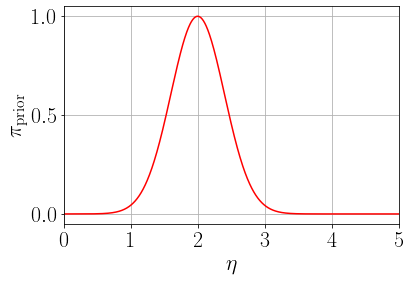

In [63]:
mean_prior = 2.0  # mean modulus for the prior
sd_prior = 0.4   # standard deviation (SD) for the prior
etaplot = np.linspace(0,5,1000) # solely used for plotting

# define the Gaussian prior
def prior(param,mean,sd):
  return np.exp(-(param-mean)**2/(2*sd**2)) / (sd*np.sqrt(2*np.pi))

# plot the prior
plt.plot(etaplot,prior(etaplot,mean_prior,sd_prior),'r') 
plt.xlim([0, 5])
plt.xlabel("$\\eta$")
plt.ylabel("$\\pi_\\mathrm{prior}$")
plt.grid()
plt.show()

Next, we will discuss the likelihood, which was denoted by $\pi(\boldsymbol{y}|\boldsymbol{m})$). The likelihood should be interpreted as a function of the parameters $\boldsymbol{m}$: for a given parameter set $\boldsymbol{m}$ it measures how "likely" it is to observe the data $\boldsymbol{y}$. Since we consider it a function of $\boldsymbol{m}$, it is not a PDF: integration over $M$ will not necessarily yield a value of one. For brevity, we introduce the short-hand notation $$\pi(\boldsymbol{y}|\boldsymbol{m})=L(\boldsymbol{m})\text{.}$$

As explained above, we use a Gaussian model for the noise with a mean of zero and a SD of $\sigma_\text{noise}$. For a single measurement point, the likelihood should thus by maximum when the measured data equals the model prediction, and it should drop-off with the same $\sigma_\text{noise}$. For multiple data points we simply multiply all values of the likelihood of a single measurment: $$L(\boldsymbol{m}) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi}\sigma_\text{noise}}\exp \left(-\frac{||\boldsymbol{g}_i(\boldsymbol{m}) - \boldsymbol{y}_i||^2}{2 \sigma_\text{noise}^2}\right)\text{.}$$

For the Newtonian model we thus obtain: $$L(\eta) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi}\sigma_\text{noise}}\exp \left(-\frac{(\tau^\text{e}_i - \eta \dot{\gamma}_i)^2}{2 \sigma_\text{noise}^2}\right)\text{.}$$ In general, we of course do not know how the data was generated, and the noise model must come from, e.g., specifications of the experimental equipment. Moreover, the parameters of the noise model can also be included in the inference, but this goes beyond the scope of this notebook.

The location of the maximum of the likelilhood itself could be used to infer the viscosity in this case. This yields a point estimate called the maximum likelihood estimate (MLE). However, full Bayesian inference using Bayes rule has some disctinct advantages:
- it yields the full posterior probability distribution, which is extremely useful for quantifying uncertatinty
- it very naturally allows for the incorporation of prior knowledge

The likelihood is plotted in the next cell, where also the MLE is calculated.

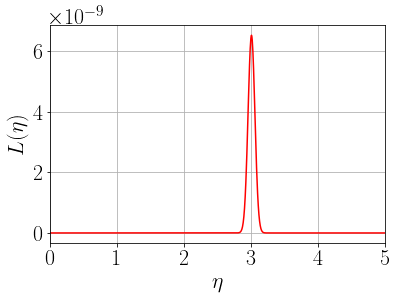

MLE =  [3.0069802]


In [64]:
# define the likelihood function
def lhood(param,dat,inp,sd):
  return np.product(np.exp(-(dat-inp*param)**2/(2*sd**2))/(sd*np.sqrt(2*np.pi)))

lhoodplot = np.zeros(len(etaplot))

for i,val in enumerate(etaplot):
  lhoodplot[i] = lhood(etaplot[i],tau,gammadot,sd_noise)

# plot the likelihood
plt.plot(etaplot,lhoodplot,'r') 
plt.xlim([0, 5])
plt.xlabel("$\\eta$")
plt.ylabel("$L(\\eta)$")
plt.grid()
plt.show()

# find the MLE
MLE = opt.fmin(lambda x: -lhood(x,tau,gammadot,sd_noise),3,xtol=1e-9,disp=False)
print('MLE = ',MLE)

As an interesting side-note, the MLE with a Gaussian noise model yields the exact same result for the estimated modulus as a least squares approach. This can easily be seen when taking the natural logarithm of the likelihood function: $$\log(L(\eta)) = -\frac{N\log(2\pi)}{2} -N \log(\sigma_\text{noise}) - \frac{1}{2\sigma_\text{noise}^2} \sum_{i=1}^N(\tau^\text{e}_i- \eta \dot{\gamma}_i)^2\text{.}$$  The logarithm is a monotonically increasing function, thus maximizing the likelihood yields the same result as maximizing the log likelihood. Moreover, the constant factors in $\log(L(\eta))$ do not play a role in the location of the maximum, and it can be observed that maximizing the log likelihood is equivalent to minimizing the term $\sum_{i=1}^N(\tau^\text{e}_i - \eta \dot{\gamma}_i)^2$, i.e. as the least squares estimate (LSE).

Here we calculate the LSE to show that the result is equivalent to the MLE.

In [65]:
# define the function used in the least-squares fitting
def func(x, eta): return eta*x

eta0 = np.array([0.0]) # initial guess

# perform a least-square estimate (LSE) of the viscosity
coefs = opt.curve_fit(func, gammadot, tau, eta0 )

print('LSE = ',coefs[0][0])

LSE =  3.006980203315018


Using Bayes rule, we can write an analytical expression for the posterior (up to a normalization constant). We get $$\pi(\eta|\tau^\text{e})\propto \exp (-\frac{(\eta-\bar{\eta}_\text{prior})}{2\sigma_\text{prior}^2}-\frac{\sum_{i=1}^N(\tau^\text{e}_i - \eta \dot{\gamma}_i)^2}{2\sigma_\text{noise}^2})\text{,}$$ which can be written in an explicity Gaussian form (by matching coefficients for $\eta^2$ and $\eta$): $$\pi(\eta|\tau^\text{e})\propto \exp (-\frac{(\eta-\bar{\eta}_\text{post})^2}{2\sigma_\text{post}^2})\text{,}$$ where the mean of the posterior is given by $$\bar{\eta}_\text{post} = \frac{\sigma_\text{noise}^2 \bar{\eta}_\text{prior}+\sigma_\text{prior}^2 \sum_{i=1}^N \dot{\gamma}_i \tau^\text{e}_i }{\sigma_\text{noise}^2 +\sigma_\text{prior}^2 \sum_{i=1}^N \dot{\gamma}_i^2 }\text{,}$$ 
and the standard deviation of the posterior is given by $$\sigma_\text{post}=\sqrt{\frac{\sigma_\text{noise}^2 \sigma_\text{prior}^2}{\sigma_\text{noise}^2+\sigma_\text{prior}^2 \sum_{i=1}^N \dot{\gamma}_i^2}}\text{.}$$

In [66]:
# calculate the mean and SD of the posterior for the viscosity
# nsample > 1: include an increasing amount of data points

# initialize some arrays
mean_post = np.zeros(nsample) 
sd_post = np.zeros(nsample)

# calculate the mean and SD of the posterior using an increasing amount of
# data points (the final one uses all datapoints)
for i in range(nsample):
  mean_post[i] = \
    ( sd_noise**2*mean_prior + sd_prior**2*sum(tau[:i+1]*gammadot[:i+1]) ) / \
      ( sd_noise**2 + sd_prior**2 * sum(gammadot[:i+1]**2) )
  sd_post[i] = np.sqrt ( ( sd_noise**2 * sd_prior**2 ) / \
    ( sd_noise**2 + sd_prior**2*sum(gammadot[:i+1]**2) ) )

# show the last value of the mean and the SD (which uses all data points)
print('posterior mean = ',mean_post[-1])
print('posterior SD = ',sd_post[-1])

posterior mean =  2.990894257568708
posterior SD =  0.05055601391655587


In the next cell we plot the posterior distribution for $\eta$ using an increasing amount of data points. It can be seen that the distribution is heavily influenced by the prior for few data points. However, it becomes more and more centered around the real value, with a decreasing SD, as the number of data points is increased.

From this we draw an important conclusion: increasing the amount of data increases our confidence about the parameters and decreases the influence of the prior.

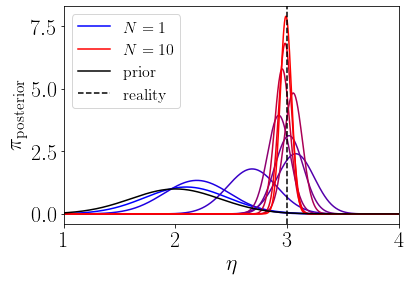

In [67]:
# plot the posterior and prior for the viscosity
# the pdfs are "normalized" with an estimate of the area
npoints = 1000
eta_vec = np.linspace(0,5,npoints)
d_eta = (eta_vec[-1]-eta_vec[0])/len(eta_vec)
post = np.zeros([nsample,npoints])

prior_vec = np.exp( -(eta_vec-mean_prior)**2 / (2*sd_prior**2) )

#fac = (1/(nsample+1)) # scale with predetermined factor
fac = 1.0/(sum(d_eta*prior_vec)) # scale with an estimate of the area

prior_vec = fac*prior_vec

for i in range (nsample):
  
  post[i,:] = np.exp( -(eta_vec-mean_post[i])**2 / (2*sd_post[i]**2) )

  #fac = ((i+2)/(nsample+1)) # scale with predetermined factor
  fac = 1.0/(sum(d_eta*post[i,:])) # scale with an estimate of the area

  post[i,:] = fac*post[i,:]

  # set the color of the line to plot
  if nsample == 1:
    color = (1,0,0)
  else:
    color = (i/(nsample-1),0,1-i/(nsample-1)) # gradient in color

  # only add labels to the first and last line
  if i == 0 or i == nsample-1:
    plt.plot(eta_vec,post[i,:],label='$N = '+str(i+1)+'$',color=color)
  else:
    plt.plot(eta_vec,post[i,:],color=color)

# add the prior and the real value to the plot
plt.plot(eta_vec,prior_vec,'k',label='$\\mathrm{prior}$')
plt.axvline(x=eta,color='k',linestyle='--',label='$\\mathrm{reality}$')
plt.xlabel("$\\eta$")
plt.ylabel("$\\pi_\\mathrm{posterior}$")
plt.legend( prop={'size': 16})
plt.xlim([1, 4])
plt.show()

Next, we will see how we can use the posterior to make predictions about future measurements. Thus we are interested in outputs $\boldsymbol{y}^\text{new}$, which might correspond to the same values or to new values of the determinstic parameters. One obvious approach is to directly use the posterior for the model parameters, for example by considering the region that contains 95% of the probability, and pluggin this into the forward model. This region is in Bayesian statistics referred to as the credible interval and is the Bayesian counterpart of the confidence interval used in frequentist statistics (but the interpretation is different: see https://robjhyndman.com/hyndsight/intervals/). 

However, only considering the credible interval for predictions does not give a complete picture. This is because there are two sources of uncertainty that need to be considered: the uncertainty on the parameter value (the posterior) and the uncertainty that for a given parameter value, new data will be observed (which is simply the likelihood but plugging in $\boldsymbol{y}^\text{new}$). To include the full uncertainty in our predictions, we must therefore integrate the likelihood times the posterior over the all possible values of the parameters, which yields the posterior **predictive** distribution: $$\pi(\boldsymbol{y}^\text{new}|\boldsymbol{y})=\int_M \pi(\boldsymbol{y}^\text{new}|\boldsymbol{m})\pi(\boldsymbol{m}|\boldsymbol{y}) d\boldsymbol{m} \text{.}$$ 

*I'M PRETTY SURE THE FOLLOWING IS INCORRECT:
The expressions written above can be interpreted as the summation of two (Gaussian) random variables (see https://en.wikipedia.org/wiki/Convolution_of_probability_distributions). It can be shown that the resulting distribution is itself a Gaussian, with a mean and SD depending on the mean and SD of the individual distribution (https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables). The posterior predictive distrbution can thus be written as: $$\pi(\boldsymbol{y}^\text{new}|\boldsymbol{y})\propto \exp (-\frac{(\boldsymbol{g}(\boldsymbol{m})-\bar{y}_\text{ppd})^2}{2\sigma_\text{ppd}^2})\text{,}$$ 
where (since the mean of the noise is zero) $$\bar{\boldsymbol{y}}_\text{ppd}=\bar{\boldsymbol{y}}_\text{post}\text{,}$$ 
and $$\sigma^2_\text{ppd}=\sigma_\text{noise}^2+\sigma^2_\text{post}\text{.}$$*

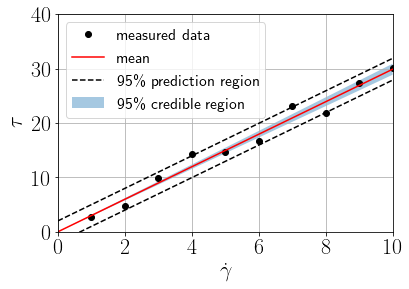

In [68]:
# mean and SD of the posterior predictive distribution
mean_ppd = mean_post[-1]
sd_ppd = np.sqrt(sd_post[-1]**2+sd_noise**2)

# plot the 95% predictions
gammadot_all = np.linspace(0,10,1000)
plt.plot(gammadot,tau,'ko',label='measured data') 
plt.plot(gammadot_all,gammadot_all*mean_post[-1],'r',label='mean')
plt.plot(gammadot_all,gammadot_all*mean_ppd+2*sd_ppd,'k--',label='95\% prediction region')
plt.plot(gammadot_all,gammadot_all*mean_ppd-2*sd_ppd,'k--')
plt.fill_between(gammadot_all,gammadot_all*(mean_post[-1]+2*sd_post[-1]), \
     gammadot_all*(mean_post[-1]-2*sd_post[-1]), alpha=0.4, label='95\% credible region')
plt.xlim([0, 10])
plt.ylim([0, 40])
plt.xlabel("$\\dot{\\gamma}$")
plt.ylabel("$\\tau$")
plt.legend( prop={'size': 16})
plt.grid()
plt.show()

Next, we will use a numerical approach to determine the posterior. Since we expect our likelihood to contain very small numbers (multiplying many probabilites), we prefer to work with the natural logarithm of the likelihood (as introduced above). Morever, we will also use the natural logarithm of the prior.

In [69]:
# define the likelihood and prior functions
def loglhood(param,dat,inp,sd):
  N = len(dat)
  return -(N/2)*np.log(2*np.pi)-N*np.log(sd)-np.sum((dat-inp*param)**2)/(2*sd**2)

def logprior(param,mean,sd):
  return -(param-mean)**2/(2*sd**2) - np.log(sd*np.sqrt(2*np.pi))


To sample from the posterior, we use Markov Chain Monte Carlo (MCMC), specifically the Metropolis-Hasting algorithm. 

In [70]:
# perform MCMC to sample from the posterior
xp = 0.4 # initial guess
ns = 50000
gamma = 0.3 # tuned to yield about 20 to 25 % acceptance 
            # see: https://www.maths.lancs.ac.uk/~sherlocc/Publications/rwm.final.pdf
xp_all = np.zeros(ns)
xp_all[0] = xp

accept = 0

for i in range(ns):
  xi = np.random.normal(xp, gamma )
  # min ([1, prob]) not included for speed (and result is equal)
  prob = np.exp(loglhood(xi,tau,gammadot,sd_noise)+logprior(xi,mean_prior,sd_prior) \
               -loglhood(xp,tau,gammadot,sd_noise)-logprior(xp,mean_prior,sd_prior))

  if np.random.uniform(0,1) < prob: 
    xp = xi; 
    accept += 1

  xp_all[i] = xp

burn_in = int(ns/5)
posterior = xp_all[burn_in:]

print("MCMC")
print(posterior.mean(axis=0))
print(posterior.std(axis=0))

print("Analytical:")
print(mean_post[-1])
print(sd_post[-1])

print("Acceptance:")
print(100*accept/ns,'%')

MCMC
2.990732401465072
0.04993395730075655
Analytical:
2.990894257568708
0.05055601391655587
Acceptance:
20.8 %


Finally, we plot the results of the MCMC and compare it to the analytical solution.

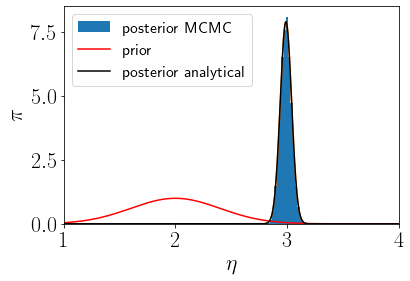

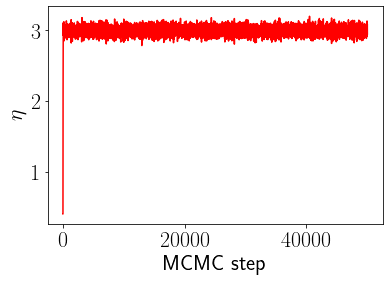

In [71]:
# plot the histogram of the MCMC
plt.figure(0)
plt.hist(posterior, 20, density=True, label='posterior MCMC')
plt.plot(eta_vec,post[-1,:])

xx=np.linspace(0,5,1000)

plt.plot(xx,np.exp(logprior(xx,mean_prior,sd_prior)),'r',label='prior')
plt.plot(eta_vec,post[-1,:],'k',label='posterior analytical')
plt.xlim([1, 4])
plt.xlabel("$\\eta$")
plt.ylabel("$\\pi$")
plt.legend( prop={'size': 16})
plt.show()

plt.figure(1)
plt.plot(xp_all,'r')
plt.xlabel("MCMC step")
plt.ylabel("$\\eta$")
plt.show()

An alternative for MCMC is to numerically integrate the denominator using standard methods (mid-point, trapezoidal, Gauss, etc.), and to just sample the posterior on a fixed grid for the parameter values. Of course, this is only feasible for a few parameters, since the amount of integration point goes op exponentially (curse of dimensionality). Here we perform this numerical integration, and show that it is exactly the same as the other approaches.

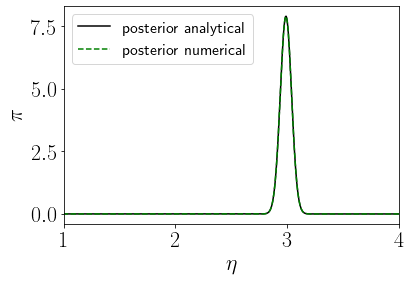

In [72]:
import scipy.integrate as integrate

npoints = 1000
eta_int=np.linspace(0,5,npoints)
lpp = np.linspace(1,4,npoints)
for i,etai in enumerate(eta_int):
  lpp[i] = lhood(etai,tau,gammadot,sd_noise)*prior(etai,mean_prior,sd_prior)
normC = integrate.trapz(y=lpp, x=eta_int)

plt.plot(eta_vec,post[-1,:],'k',label='posterior analytical')
plt.plot(eta_int,lpp/normC,'g--',label='posterior numerical')
plt.xlim([1, 4])
plt.xlabel("$\\eta$")
plt.ylabel("$\\pi$")
plt.legend( prop={'size': 16})
plt.show()